Saving train.csv to train.csv
Saving test.csv to test.csv
Saving validation.csv to validation (1).csv
Degree=1, C=0.0, Test Accuracy: 0.3571
Degree=1, C=0.1, Test Accuracy: 0.6429
Degree=1, C=1.0, Test Accuracy: 0.8571
Degree=1, C=10.0, Test Accuracy: 0.8571
Degree=1, C=25.0, Test Accuracy: 0.8571
Degree=1, C=50.0, Test Accuracy: 0.8571
Degree=1, C=75.0, Test Accuracy: 0.8571
Degree=1, C=100.0, Test Accuracy: 0.8571
Degree=1, C=250.0, Test Accuracy: 0.8571
Degree=1, C=500.0, Test Accuracy: 0.8571
Degree=1, C=1000.0, Test Accuracy: 0.8571
Degree=2, C=0.0, Test Accuracy: 0.3571
Degree=2, C=0.1, Test Accuracy: 0.3571
Degree=2, C=1.0, Test Accuracy: 0.8571
Degree=2, C=10.0, Test Accuracy: 0.8571
Degree=2, C=25.0, Test Accuracy: 0.9286
Degree=2, C=50.0, Test Accuracy: 0.9286
Degree=2, C=75.0, Test Accuracy: 0.9286
Degree=2, C=100.0, Test Accuracy: 0.9286
Degree=2, C=250.0, Test Accuracy: 0.9286
Degree=2, C=500.0, Test Accuracy: 0.9286
Degree=2, C=1000.0, Test Accuracy: 0.9286
Degree=3, C=0.

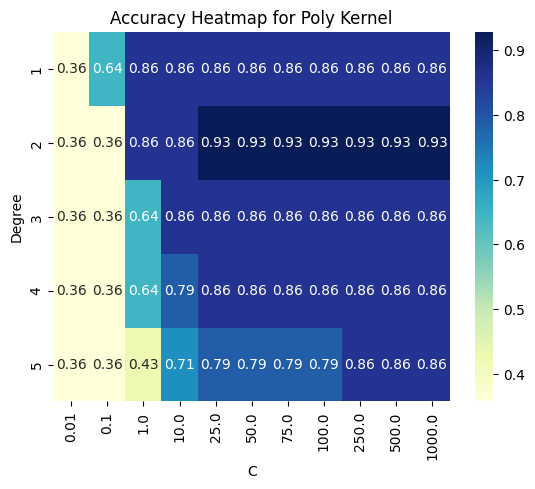

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from google.colab import files
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


uploaded = files.upload()

# Load the mobile data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Concatenate train and test data
data = pd.concat([train, test], axis=0)

# Separate features and target variable
X = data.drop(columns=['Label'])
y = data['Label']

# First, split into training+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Then split the temp (80%) into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=123, stratify=y_temp)
# 0.25 x 0.8 = 0.2 ⇒ 60% train, 20% val, 20% test

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize variables to track the best model and its accuracy
best_accuracy = 0
best_params = {'degree': None, 'C': None}

# Initialize a list to store scores
scores = []

# Iterate over degrees 1 through 4 and C values
degree_range = range(1, 6) #changing degree range from (1, 5) to (1,6) makes no difference on accuracy score
C_range = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000] #change in C_range parameters does not affect accuracy score at all, still achieves 0.9333 accuracy

for degree in degree_range:
    for C in C_range:
        # Initialize the SVC with polynomial kernel
        # uses polynomial degrees (like parabolas, cubic curve) to draw decision boundary
        model = SVC(kernel='poly', degree=degree, C=C, random_state=123)

        # Train the model on the scaled training data
        model.fit(X_train_scaled, y_train)

        # Predict on the validation set and calculate accuracy
        y_val_pred = model.predict(X_val_scaled)
        accuracy = accuracy_score(y_val, y_val_pred)


        print(f"Degree={degree}, C={C:.1f}, Test Accuracy: {accuracy:.4f}")

        # Store the score
        scores.append([degree, C, accuracy])

        # Update the best parameters if current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['degree'] = degree
            best_params['C'] = C

# Output the best results
print("\nBest parameters found:")
print(f"Degree={degree}, C={C:.1f}, Validation Accuracy: {accuracy:.4f}")

# Retrain best model on full training set
final_model = SVC(kernel='poly', degree=best_params['degree'], C=best_params['C'], random_state=123)
final_model.fit(X_train_scaled, y_train)

# Test on held-out test set
y_test_pred = final_model.predict(X_test_scaled)
print("\nFinal model on TEST set:")
print(classification_report(y_test, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# After collecting scores show heatmap of results for this kernel
results = pd.DataFrame(scores, columns=['Degree', 'C', 'Accuracy'])
# Use pivot_table if using pandas version < 1.1.0
heatmap_data = results.pivot_table(index='Degree', columns='C', values='Accuracy')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('Accuracy Heatmap for Poly Kernel')
plt.show()

Fitting 3 folds for each of 55 candidates, totalling 165 fits

Best poly kernel params: {'C': 10, 'degree': 1, 'kernel': 'poly'}
Best cross-val (train) accuracy: 0.9487

Validation set accuracy: 0.8571
              precision    recall  f1-score   support

     ChatGPT       0.75      1.00      0.86         3
    LinkedIn       0.80      1.00      0.89         4
      Reddit       0.00      0.00      0.00         2
   Wikipedia       1.00      1.00      1.00         5

    accuracy                           0.86        14
   macro avg       0.64      0.75      0.69        14
weighted avg       0.75      0.86      0.79        14


Test set accuracy: 0.9286
              precision    recall  f1-score   support

     ChatGPT       1.00      1.00      1.00         3
    LinkedIn       1.00      1.00      1.00         4
      Reddit       1.00      0.67      0.80         3
   Wikipedia       0.80      1.00      0.89         4

    accuracy                           0.93        14
   macro a

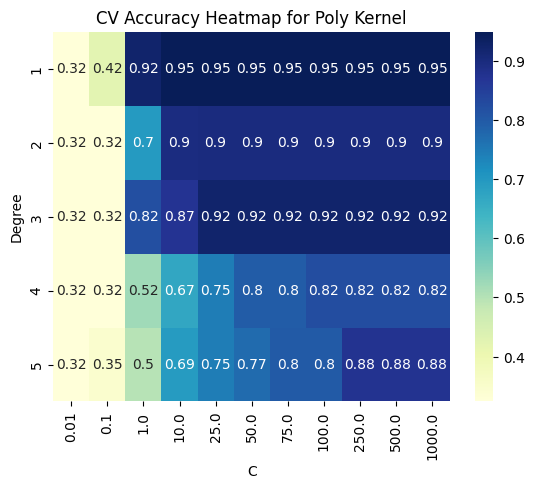

In [7]:
from sklearn.model_selection import GridSearchCV

# Define the param grid for just the poly kernel
param_grid_poly = {
    'C': [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000],
    'degree': range(1, 6),
    'kernel': ['poly']
}

# Initialize the model
model_poly = SVC(random_state=123)

# Run grid search on just the training data
grid_poly = GridSearchCV(model_poly, param_grid_poly, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_poly.fit(X_train_scaled, y_train)

# Best parameters from GridSearch
print(f"\nBest poly kernel params: {grid_poly.best_params_}")
print(f"Best cross-val (train) accuracy: {grid_poly.best_score_:.4f}")

# Evaluate on validation set (not used in grid search)
y_val_pred = grid_poly.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"\nValidation set accuracy: {val_acc:.4f}")
print(classification_report(y_val, y_val_pred, zero_division=0))

# Evaluate on test set
y_test_pred = grid_poly.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nTest set accuracy: {test_acc:.4f}")
print(classification_report(y_test, y_test_pred))

# Heatmap
results_poly = pd.DataFrame(grid_poly.cv_results_)
heatmap_data = results_poly.pivot_table(index='param_degree', columns='param_C', values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('CV Accuracy Heatmap for Poly Kernel')
plt.xlabel("C")
plt.ylabel("Degree")
plt.show()

In [9]:
best_accuracy = 0
best_C = None
best_degree = None

# Iterate over degrees 1 through 4
degree_range = range(1, 5)
C_range = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000]

for degree in degree_range:
    for C in C_range:
        # Initialize the SVC with sigmoid kernel
        model = SVC(kernel='sigmoid', degree=degree, C=C, random_state=123)

        # Train the model on the scaled training data
        model.fit(X_train_scaled, y_train)

        # Predict on the validation set instead of test set
        y_val_pred = model.predict(X_val_scaled)
        accuracy = accuracy_score(y_val, y_val_pred)
        print(f"Degree={degree}, C={C:.1f}, Validation Accuracy: {accuracy:.4f}")

        # Update best parameters if current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C = C
            best_degree = degree

# Output the best results
print("\nBest parameters found (on validation set):")
print(f"Degree={best_degree}, C={best_C}, Validation Accuracy: {best_accuracy:.4f}")

# Retrain on full train set and evaluate on test set
final_model = SVC(kernel='sigmoid', degree=best_degree, C=best_C, random_state=123)
final_model.fit(X_train_scaled, y_train)
y_test_pred = final_model.predict(X_test_scaled)

print("\nFinal model performance on Test set:")
print(classification_report(y_test, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Degree=1, C=0.0, Validation Accuracy: 0.3571
Degree=1, C=0.1, Validation Accuracy: 0.6429
Degree=1, C=1.0, Validation Accuracy: 0.8571
Degree=1, C=10.0, Validation Accuracy: 0.9286
Degree=1, C=25.0, Validation Accuracy: 0.9286
Degree=1, C=50.0, Validation Accuracy: 0.9286
Degree=1, C=75.0, Validation Accuracy: 0.9286
Degree=1, C=100.0, Validation Accuracy: 0.9286
Degree=1, C=250.0, Validation Accuracy: 0.9286
Degree=1, C=500.0, Validation Accuracy: 0.9286
Degree=1, C=1000.0, Validation Accuracy: 0.9286
Degree=2, C=0.0, Validation Accuracy: 0.3571
Degree=2, C=0.1, Validation Accuracy: 0.6429
Degree=2, C=1.0, Validation Accuracy: 0.8571
Degree=2, C=10.0, Validation Accuracy: 0.9286
Degree=2, C=25.0, Validation Accuracy: 0.9286
Degree=2, C=50.0, Validation Accuracy: 0.9286
Degree=2, C=75.0, Validation Accuracy: 0.9286
Degree=2, C=100.0, Validation Accuracy: 0.9286
Degree=2, C=250.0, Validation Accuracy: 0.9286
Degree=2, C=500.0, Validation Accuracy: 0.9286
Degree=2, C=1000.0, Validation A

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the param grid for sigmoid kernel — degree is NOT needed here
param_grid_sigmoid = {
    'C': [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['sigmoid']
}

# Initialize base model
model_sigmoid = SVC(random_state=123)

# Set up GridSearchCV using training data only
grid_sigmoid = GridSearchCV(model_sigmoid, param_grid_sigmoid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_sigmoid.fit(X_train_scaled, y_train)

# Best params from grid
print("\nBest sigmoid kernel parameters:")
print(grid_sigmoid.best_params_)
print(f"Best cross-validation (train) accuracy: {grid_sigmoid.best_score_:.4f}")

# Evaluate on validation set (not test set yet)
y_val_pred = grid_sigmoid.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation set accuracy: {val_accuracy:.4f}")
print(classification_report(y_val, y_val_pred))

# Final test evaluation with retrained model
final_model = SVC(**grid_sigmoid.best_params_, random_state=123)
final_model.fit(X_train_scaled, y_train)
y_test_pred = final_model.predict(X_test_scaled)

print("\nFinal model on Test set:")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 22 candidates, totalling 110 fits

Best sigmoid kernel parameters:
{'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best cross-validation (train) accuracy: 0.9500

Validation set accuracy: 0.9286
              precision    recall  f1-score   support

     ChatGPT       0.75      1.00      0.86         3
    LinkedIn       1.00      1.00      1.00         4
      Reddit       1.00      0.50      0.67         2
   Wikipedia       1.00      1.00      1.00         5

    accuracy                           0.93        14
   macro avg       0.94      0.88      0.88        14
weighted avg       0.95      0.93      0.92        14


Final model on Test set:
Test Accuracy: 0.7857
              precision    recall  f1-score   support

     ChatGPT       0.75      1.00      0.86         3
    LinkedIn       0.80      1.00      0.89         4
      Reddit       1.00      0.33      0.50         3
   Wikipedia       0.75      0.75      0.75         4

    accuracy         

C=0.01, Validation Accuracy: 0.3571
C=0.10, Validation Accuracy: 0.8571
C=1.00, Validation Accuracy: 0.8571
C=10.00, Validation Accuracy: 0.8571
C=25.00, Validation Accuracy: 0.8571
C=50.00, Validation Accuracy: 0.8571
C=75.00, Validation Accuracy: 0.8571
C=100.00, Validation Accuracy: 0.8571
C=250.00, Validation Accuracy: 0.8571
C=500.00, Validation Accuracy: 0.8571
C=1000.00, Validation Accuracy: 0.8571

Best parameters found:
C=0.1, Validation Accuracy: 0.8571

Final model on Test set:
              precision    recall  f1-score   support

     ChatGPT       0.75      1.00      0.86         3
    LinkedIn       0.80      1.00      0.89         4
      Reddit       0.00      0.00      0.00         2
   Wikipedia       1.00      1.00      1.00         5

    accuracy                           0.86        14
   macro avg       0.64      0.75      0.69        14
weighted avg       0.75      0.86      0.79        14

Test Accuracy: 0.7857


<ipython-input-16-5a4c97ef55af>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='C', y='Validation Accuracy', palette='viridis')


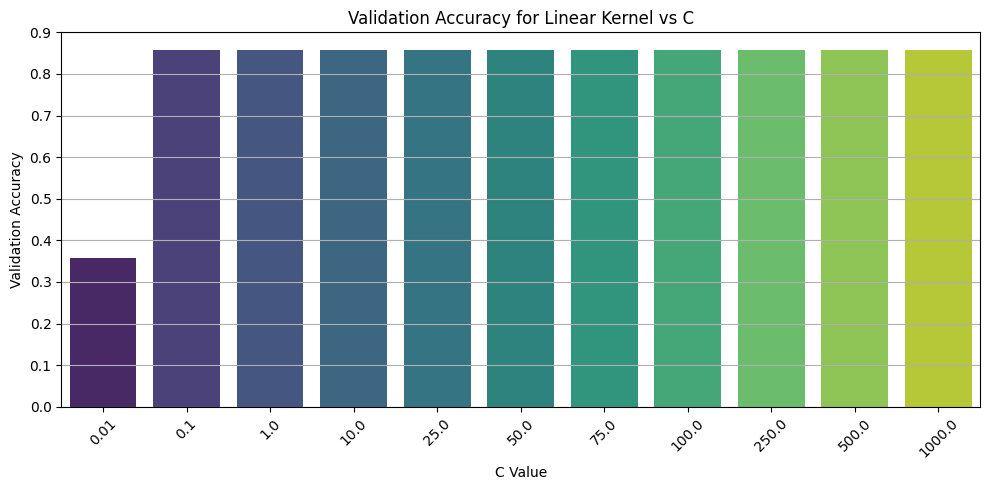

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

best_accuracy = 0
best_C = None
results = []

# Only vary C for linear kernel
C_range = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000]

for C in C_range:
    # Initialize the SVC with linear kernel (no degree needed!)
    model = SVC(kernel='linear', C=C, random_state=123)

    # Train on training set
    model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_val_pred)
    results.append((C, accuracy))
    print(f"C={C:.2f}, Validation Accuracy: {accuracy:.4f}")

    # Track the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

# Output best C found from validation
print("\nBest parameters found:")
print(f"C={best_C}, Validation Accuracy: {best_accuracy:.4f}")

# Retrain on full training set with best C
final_model = SVC(kernel='linear', C=best_C, random_state=123)
final_model.fit(X_train_scaled, y_train)

# Evaluate on test set
y_test_pred = final_model.predict(X_test_scaled)
print("\nFinal model on Test set:")
print(classification_report(y_val, y_val_pred, zero_division=0))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['C', 'Validation Accuracy'])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='C', y='Validation Accuracy', palette='viridis')
plt.title('Validation Accuracy for Linear Kernel vs C')
plt.xlabel('C Value')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
# Initialize variables to track the best model and its accuracy
best_accuracy = 0
best_params = {'gamma': None, 'C': None}

# Define ranges for gamma and C
gamma_range = np.arange(0.0005, 0.0101, 0.0001)
C_range = [0.01, 0.1, 1, 10, 50, 100, 500, 1000]

# Track results for heatmap later
results = []

# Iterate over all combinations of gamma and C
for gamma in gamma_range:
    for C in C_range:
        # Initialize the SVC with Gaussian (RBF) kernel
        model = SVC(kernel='rbf', gamma=gamma, C=C, random_state=123)

        # Train on training data
        model.fit(X_train_scaled, y_train)

        # Predict on the validation set (NOT test set yet!)
        y_val_pred = model.predict(X_val_scaled)
        accuracy = accuracy_score(y_val, y_val_pred)

        print(f"Gamma={gamma:.4f}, C={C:.1f}, Validation Accuracy: {accuracy:.4f}")
        results.append((gamma, C, accuracy))

        # Update best params
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['gamma'] = gamma
            best_params['C'] = C

# Output best result from validation
print("\nBest parameters from validation:")
print(f"Gamma={best_params['gamma']}, C={best_params['C']}, Validation Accuracy: {best_accuracy:.4f}")

# Retrain on full training set and evaluate on test set
final_model = SVC(kernel='rbf', gamma=best_params['gamma'], C=best_params['C'], random_state=123)
final_model.fit(X_train_scaled, y_train)
y_test_pred = final_model.predict(X_test_scaled)

print("\nFinal model on Test set:")
print(classification_report(y_test, y_test_pred, zero_division=0))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Gamma=0.0005, C=0.0, Validation Accuracy: 0.3571
Gamma=0.0005, C=0.1, Validation Accuracy: 0.3571
Gamma=0.0005, C=1.0, Validation Accuracy: 0.3571
Gamma=0.0005, C=10.0, Validation Accuracy: 0.3571
Gamma=0.0005, C=50.0, Validation Accuracy: 0.8571
Gamma=0.0005, C=100.0, Validation Accuracy: 0.8571
Gamma=0.0005, C=500.0, Validation Accuracy: 0.8571
Gamma=0.0005, C=1000.0, Validation Accuracy: 0.8571
Gamma=0.0006, C=0.0, Validation Accuracy: 0.3571
Gamma=0.0006, C=0.1, Validation Accuracy: 0.3571
Gamma=0.0006, C=1.0, Validation Accuracy: 0.3571
Gamma=0.0006, C=10.0, Validation Accuracy: 0.6429
Gamma=0.0006, C=50.0, Validation Accuracy: 0.8571
Gamma=0.0006, C=100.0, Validation Accuracy: 0.8571
Gamma=0.0006, C=500.0, Validation Accuracy: 0.8571
Gamma=0.0006, C=1000.0, Validation Accuracy: 0.8571
Gamma=0.0007, C=0.0, Validation Accuracy: 0.3571
Gamma=0.0007, C=0.1, Validation Accuracy: 0.3571
Gamma=0.0007, C=1.0, Validation Accuracy: 0.3571
Gamma=0.0007, C=10.0, Validation Accuracy: 0.6429
G

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid for RBF kernel
param_grid_rbf = {
    'kernel': ['rbf'],
    'gamma': np.arange(0.0005, 0.0101, 0.0001),
    'C': [0.01, 0.1, 1, 10, 50, 100, 500, 1000]
}

# Initialize base model
model_rbf = SVC(random_state=123)

# GridSearch with 5-fold CV
grid_rbf = GridSearchCV(model_rbf, param_grid_rbf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_rbf.fit(X_train_scaled, y_train)

# Best parameters + score
print("\nBest RBF kernel parameters:")
print(grid_rbf.best_params_)
print(f"Best CV accuracy: {grid_rbf.best_score_:.4f}")

# Evaluate on test set
y_pred = grid_rbf.predict(X_test_scaled)
print("\nTest set performance:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 768 candidates, totalling 3840 fits

Best RBF kernel parameters:
{'C': 10, 'gamma': np.float64(0.002800000000000001), 'kernel': 'rbf'}
Best CV accuracy: 0.8444

Test set performance:
Test Accuracy: 0.8333
              precision    recall  f1-score   support

     ChatGPT       1.00      1.00      1.00         5
    LinkedIn       0.71      1.00      0.83        10
      Reddit       1.00      0.43      0.60         7
   Wikipedia       0.88      0.88      0.88         8

    accuracy                           0.83        30
   macro avg       0.90      0.83      0.83        30
weighted avg       0.87      0.83      0.82        30



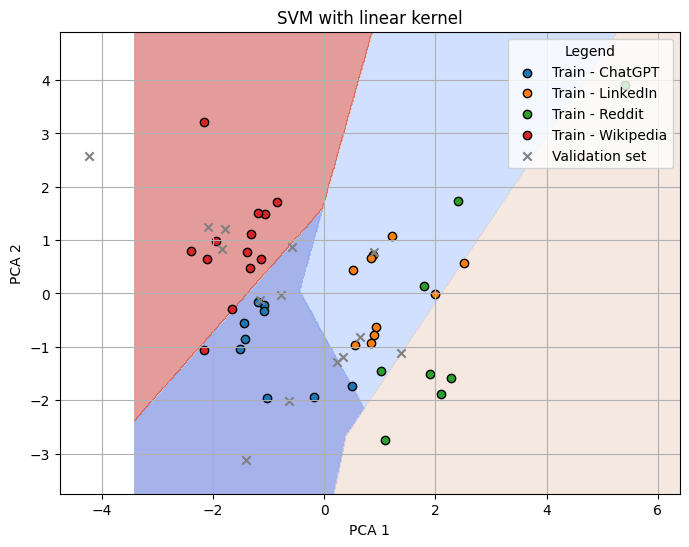

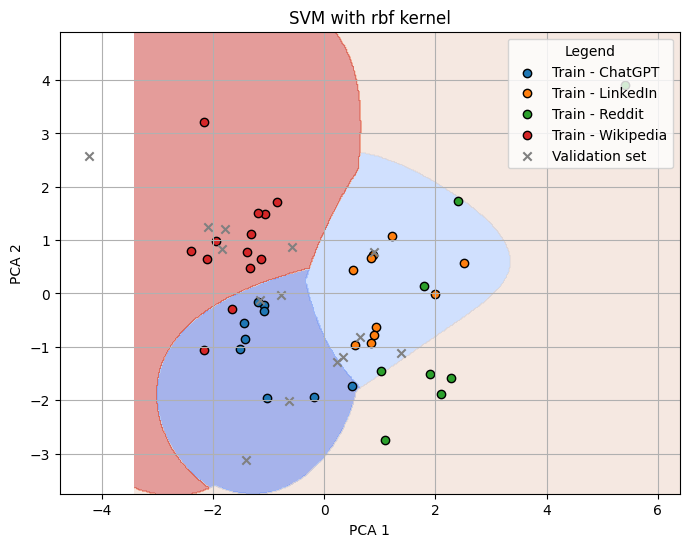

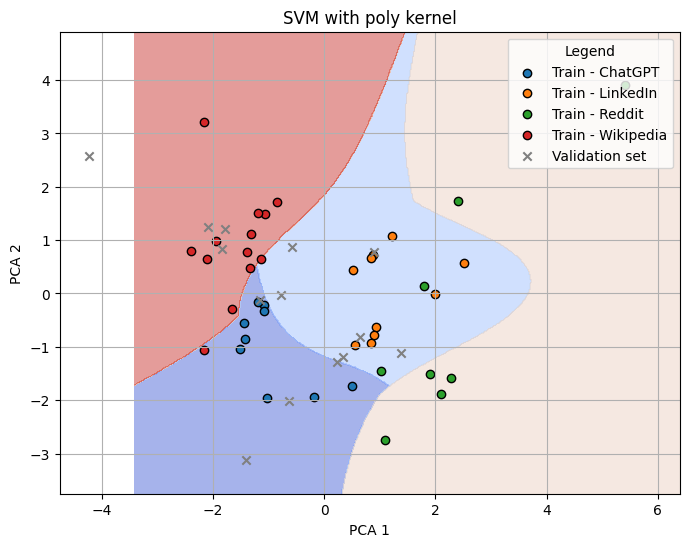

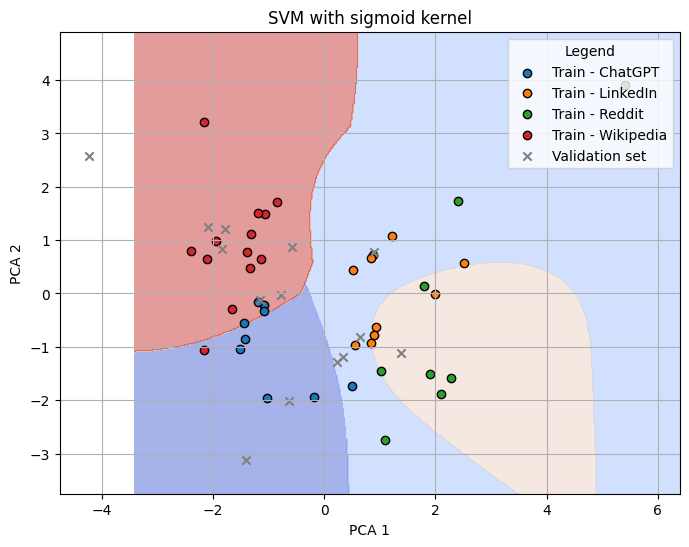

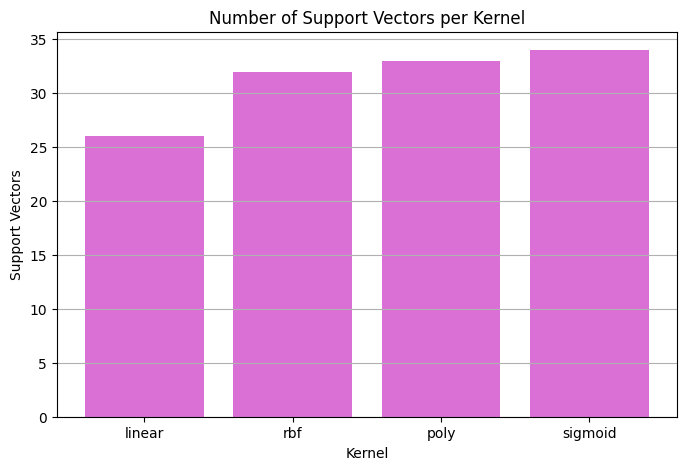

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Apply PCA to training data only (fit only on training set)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)  # Apply transform to validation set

def plot_kernel_decision_boundary(kernel, X_train_pca, y_train, X_val_pca, y_val):
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    class_names = le.classes_

    # Train model only on training PCA data
    model = SVC(kernel=kernel, gamma='scale', C=1).fit(X_train_pca, y_train_encoded)

    h = 0.02
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.5)

    # Plot training data with class-colored dots
    for idx, class_name in enumerate(class_names):
        plt.scatter(
            X_train_pca[y_train_encoded == idx, 0],
            X_train_pca[y_train_encoded == idx, 1],
            edgecolors='k', label=f"Train - {class_name}"
        )

    # Plot validation data in gray
    plt.scatter(
        X_val_pca[:, 0], X_val_pca[:, 1],
        c='gray', marker='x', label='Validation set'
    )

    # Highlight support vectors
    plt.scatter(
        model.support_vectors_[:, 0],
        model.support_vectors_[:, 1],
        s=100, facecolors='none', linewidths=1.5
    )

    plt.title(f"SVM with {kernel} kernel")
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(title='Legend', loc='upper right')
    plt.grid(True)
    plt.show()

    return model

# Kernel list and storage
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
all_models = []

# Plot each kernel decision boundary with validation points
for k in kernels:
    model = plot_kernel_decision_boundary(k, X_train_pca, y_train, X_val_pca, y_val)
    all_models.append(model)

# Bar plot of number of support vectors
plt.figure(figsize=(8, 5))
plt.bar(kernels, [model.n_support_.sum() for model in all_models], color='orchid')
plt.title("Number of Support Vectors per Kernel")
plt.xlabel("Kernel")
plt.ylabel("Support Vectors")
plt.grid(axis='y')
plt.show()
# https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py

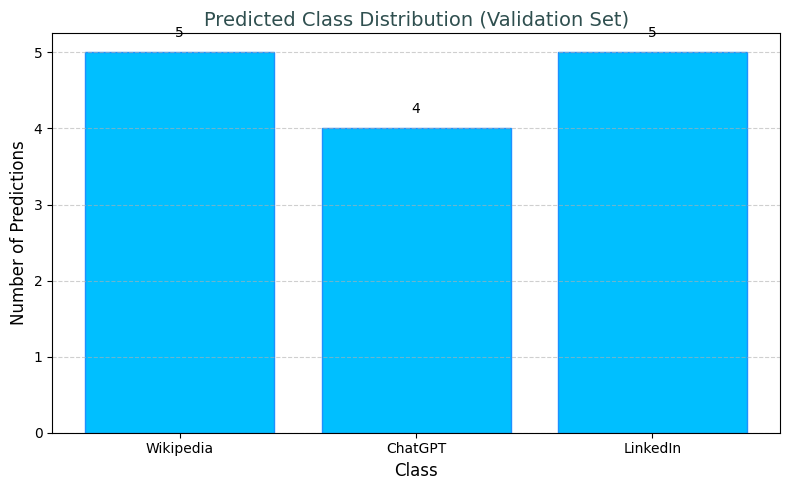

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Predict on the validation set
y_val_pred = final_model.predict(X_val_scaled)

# Count the number of predictions for each class
predicted_counts = Counter(y_val_pred)

# Map label indices back to names
label_names = {
    0: 'ChatGPT',
    1: 'Reddit',
    2: 'Wikipedia',
    3: 'LinkedIn'
}

# Prepare data for plotting
labels = [label_names.get(i, f"{i}") for i in predicted_counts.keys()]
counts = [predicted_counts[i] for i in predicted_counts.keys()]

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='deepskyblue', edgecolor='dodgerblue')
plt.title('Predicted Class Distribution (Validation Set)', fontsize=14, color='darkslategrey')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Predictions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters: {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best CV score (on Train): 1.0000

Validation set accuracy: 0.8571
              precision    recall  f1-score   support

     ChatGPT       0.75      1.00      0.86         3
    LinkedIn       0.80      1.00      0.89         4
      Reddit       0.00      0.00      0.00         2
   Wikipedia       1.00      1.00      1.00         5

    accuracy                           0.86        14
   macro avg       0.64      0.75      0.69        14
weighted avg       0.75      0.86      0.79        14


Test set accuracy: 0.9286
              precision    recall  f1-score   support

     ChatGPT       1.00      1.00      1.00         3
    LinkedIn       1.00      1.00      1.00         4
      Reddit       1.00      0.67      0.80         3
   Wikipedia       0.80      1.00      0.89         4

    accuracy                           0.93        14
   mac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


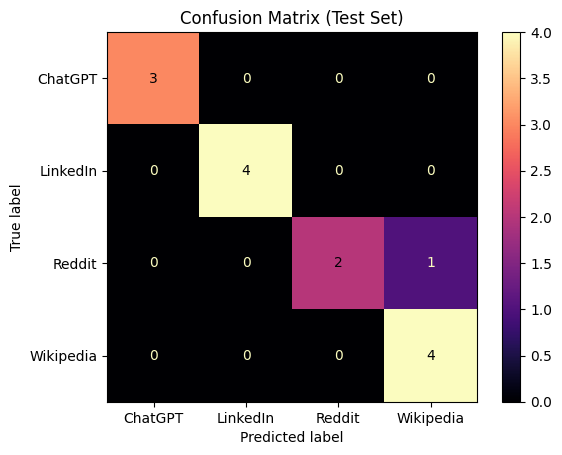

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Define the parameter grid
param_grid = {
    'kernel': ['poly', 'sigmoid', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3, 4, 5],  # Only used for 'poly'
    'C': [0.01, 0.1, 1, 10, 50, 100, 500, 1000]
}

# Initialize the model
model = SVC(random_state=123)

# GridSearchCV uses StratifiedKFold by default; still using training set only
grid = GridSearchCV(model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Best params from cross-validation
print(f"Best parameters: {grid.best_params_}")
print(f"Best CV score (on Train): {grid.best_score_:.4f}")

# Evaluate on the validation set
y_val_pred = grid.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"\nValidation set accuracy: {val_acc:.4f}")
print(classification_report(y_val, y_val_pred))

# Evaluate on the test set (final holdout)
y_test_pred = grid.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nTest set accuracy: {test_acc:.4f}")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Visualize confusion matrix for test predictions
ConfusionMatrixDisplay.from_estimator(grid, X_test_scaled, y_test, cmap='magma')
plt.title("Confusion Matrix (Test Set)")
plt.show()